# Machine Predictive Maintenance Classification

## Importing Libraries

In [295]:
# Importing libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.stats import randint

from imblearn.over_sampling import SMOTE

## Data Loading and Exploration

In [296]:
# Function to read data based on file extension.
def read_data(file_path):
    _ , file_ext = os.path.splitext(file_path)
    if file_ext == '.csv':
        return pd.read_csv(file_path)
    elif file_ext == '.json':
        return pd.read_json(file_path)
    elif file_ext in ['.xls', '.xlsx']:
        return pd.read_excel(file_path)
    else:
        raise ValueError("Unknown file format")
    
# Loading the dataset.
file_path = "predictive_maintenance.csv"
df = read_data(file_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [297]:
df.tail()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,No Failure


In [298]:
# Shape of the data.
df.shape

(10000, 10)

## Exploratory Data Analysis (EDA)

In [299]:
# Data information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [300]:
# Describing the data.
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [301]:
# Converting columns to list.
df.columns.tolist()

['UDI',
 'Product ID',
 'Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Target',
 'Failure Type']

In [302]:
# Missing values.
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [303]:
# Checking duplicate values.
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

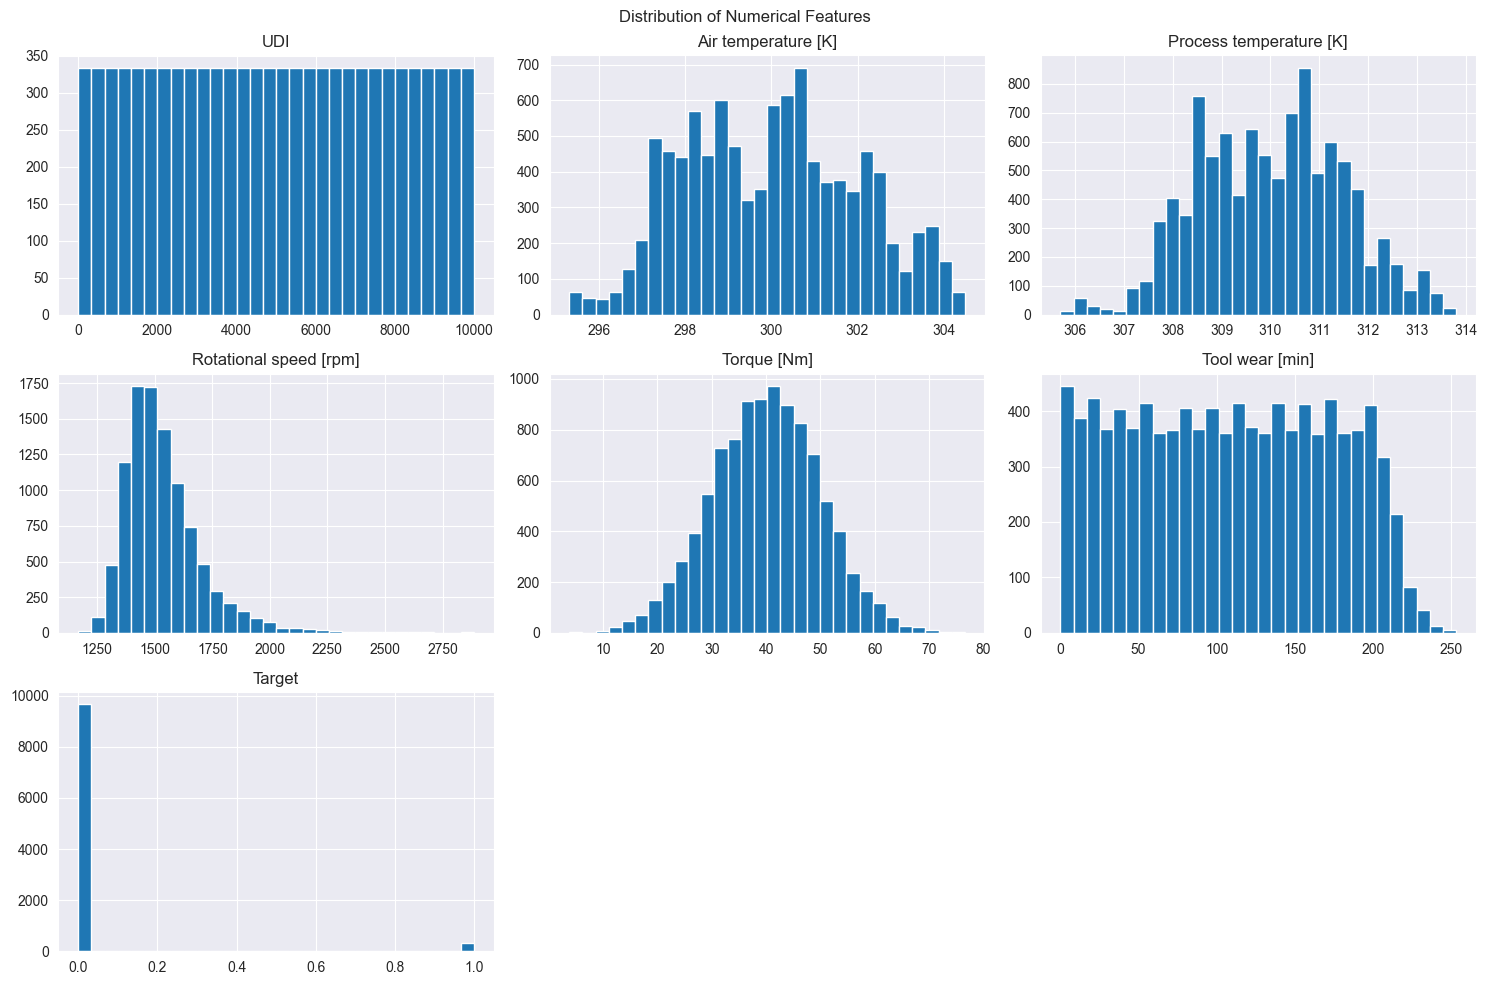

In [304]:
# Distribution of numerical features.
df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout()
plt.show()

Torque, Air temperature, and Process temperature have been approximately followed Gaussian shape while Rotational speed right skewed.

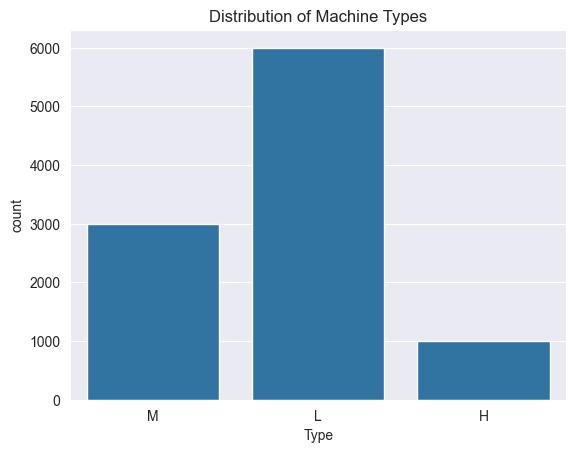

In [305]:
# Distribution of categorical features.
sns.countplot(data=df, x='Type')
plt.title('Distribution of Machine Types')
plt.show()

Low types has count 6000 which is the most frequent type among M, L, H.

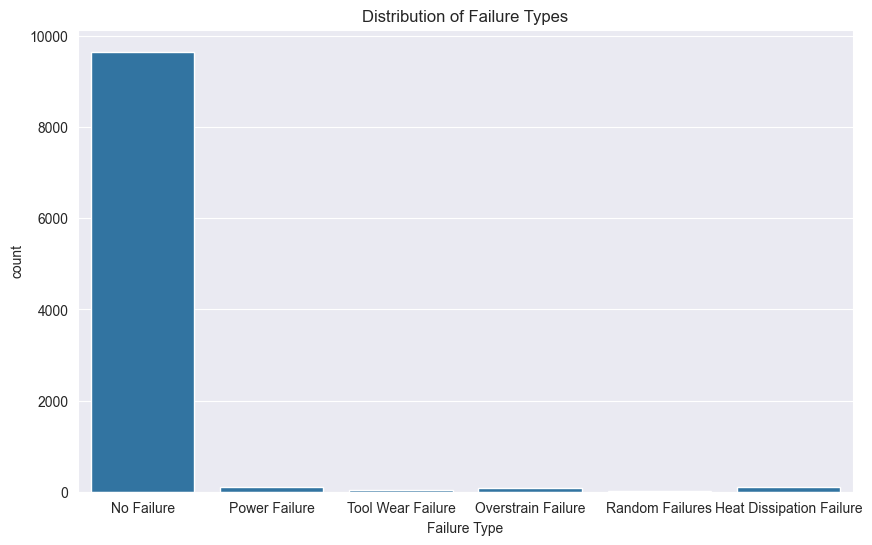

In [306]:
# Distribution of the 'Failure Type'.
plt.figure(figsize=[10,6])
sns.countplot(data=df, x='Failure Type')
plt.title('Distribution of Failure Types')
plt.show()

Majority class is No Failure while others classes are very little contribution.

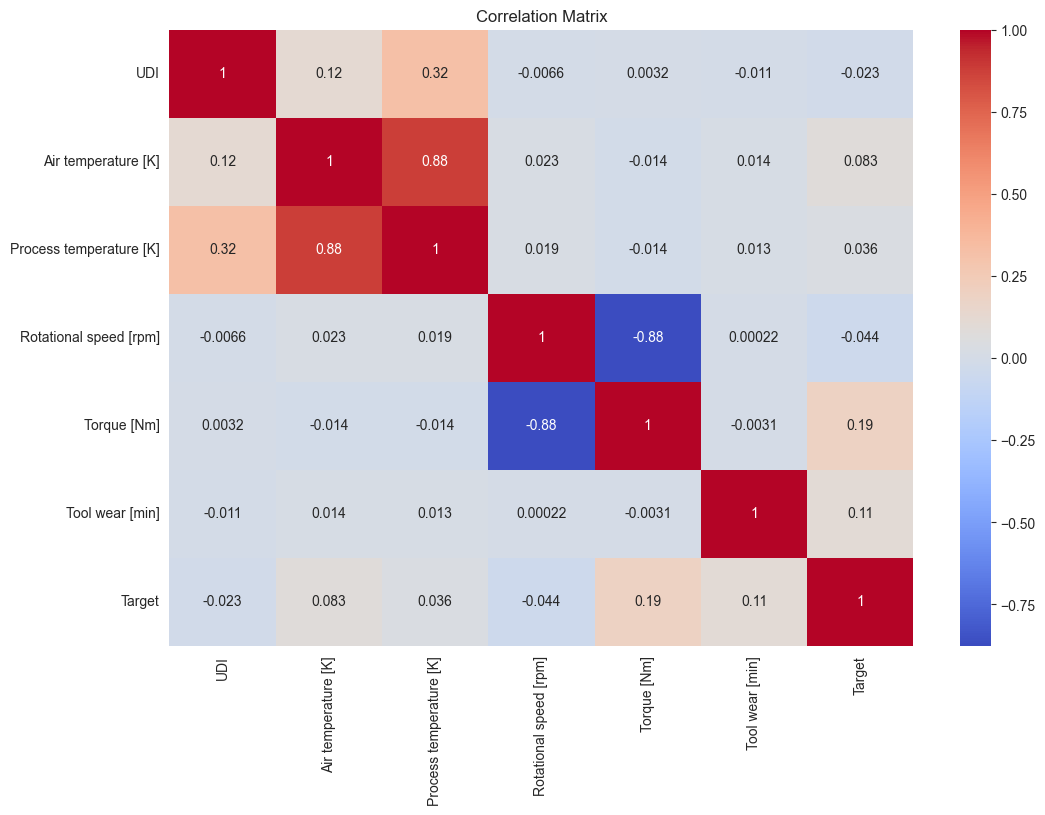

In [307]:
# Correlation matrix
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

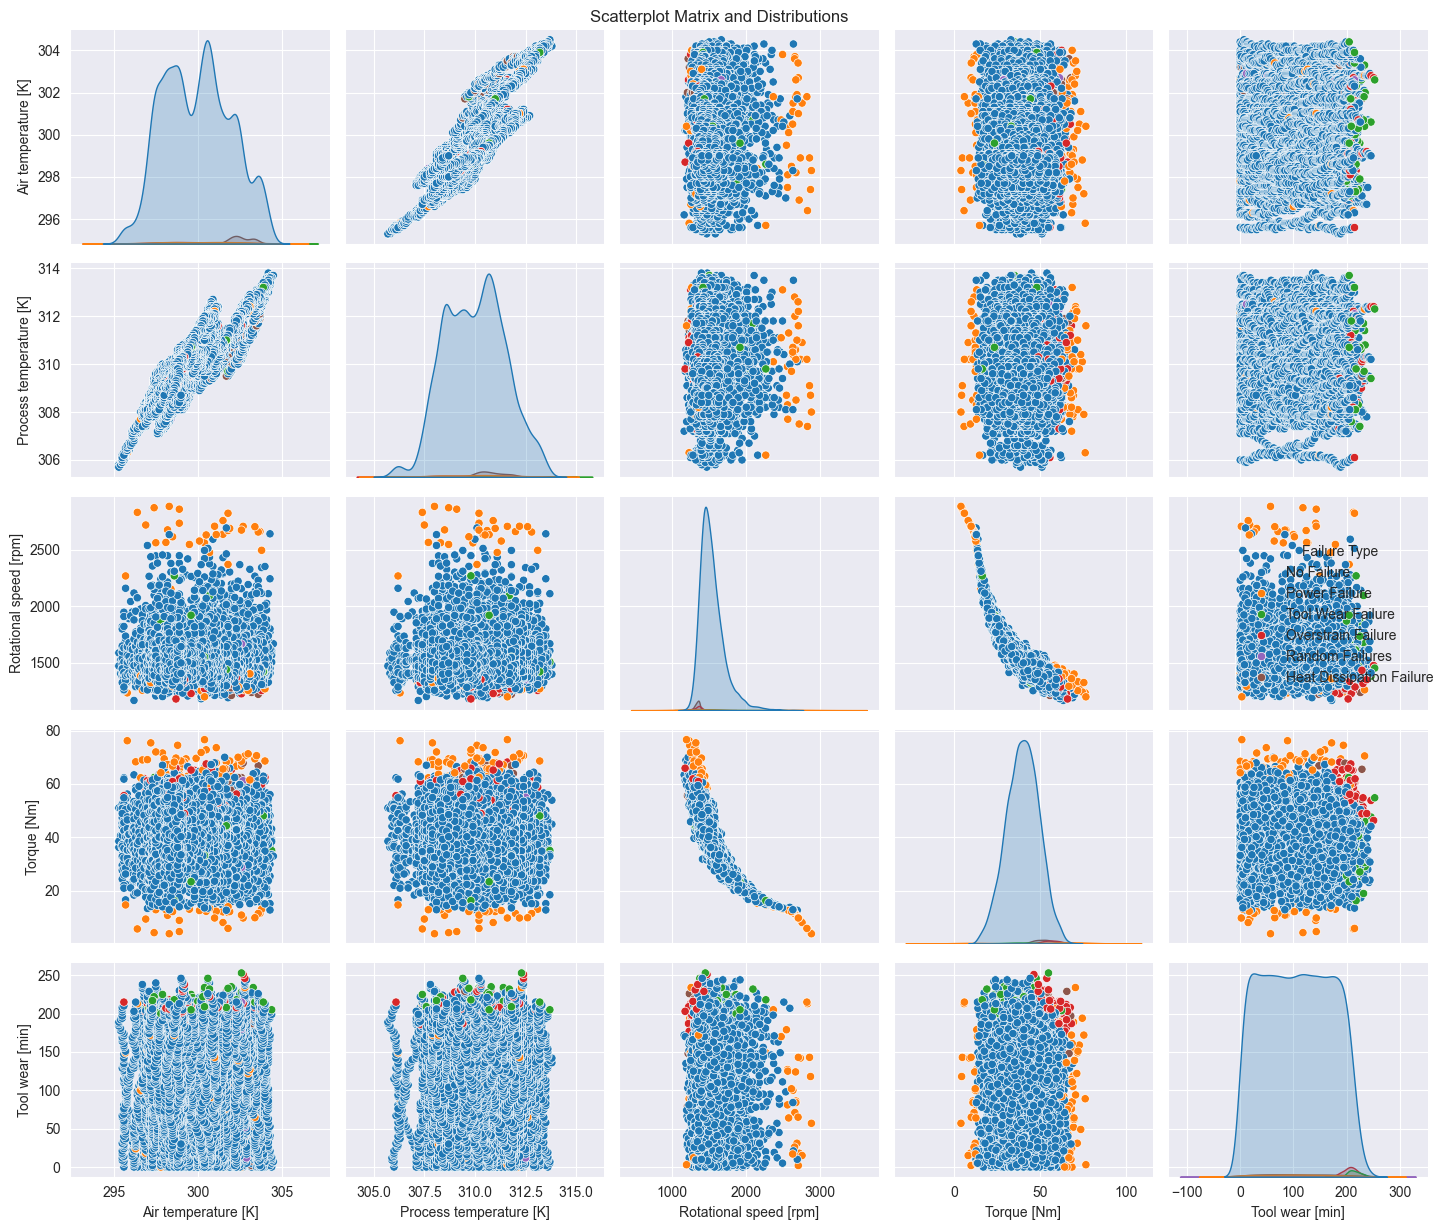

In [308]:
# Using Seaborn to create a pair plot for numerical features.  
sns.pairplot(
    df, 
    hue='Failure Type', 
    vars=[
        'Air temperature [K]', 
        'Process temperature [K]', 
        'Rotational speed [rpm]', 
        'Torque [Nm]', 
        'Tool wear [min]'
    ], 
    diag_kind='kde'
) 
plt.suptitle("Scatterplot Matrix and Distributions") 
plt.tight_layout()
plt.show()

Air temperature and Process temperature show positive correlation while Torque and Rotational Speed are showing  negative coorelation.

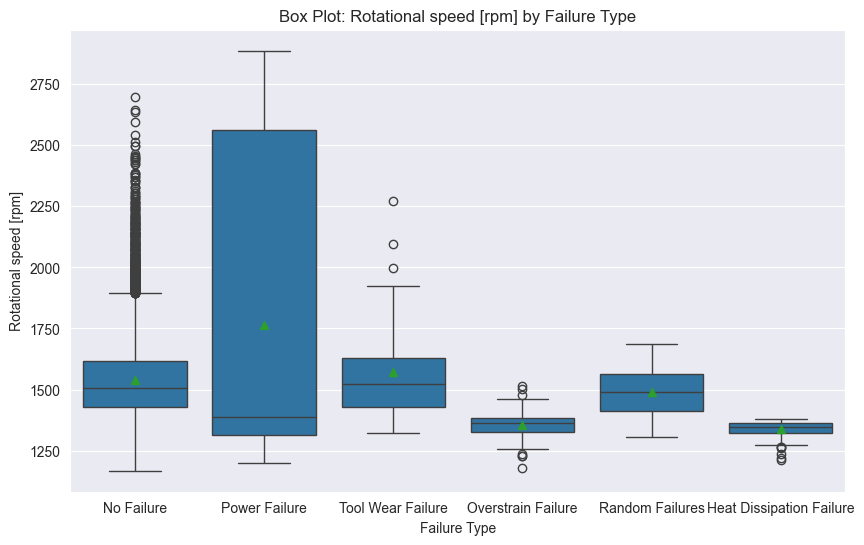

In [309]:
# Exploring Rotational speed vs Failure Type using box plots. 
plt.figure(figsize=[10,6])
sns.boxplot(
    data=df, x='Failure Type', 
    y='Rotational speed [rpm]', 
    showmeans=True
)
plt.title("Box Plot: Rotational speed [rpm] by Failure Type")
plt.show()

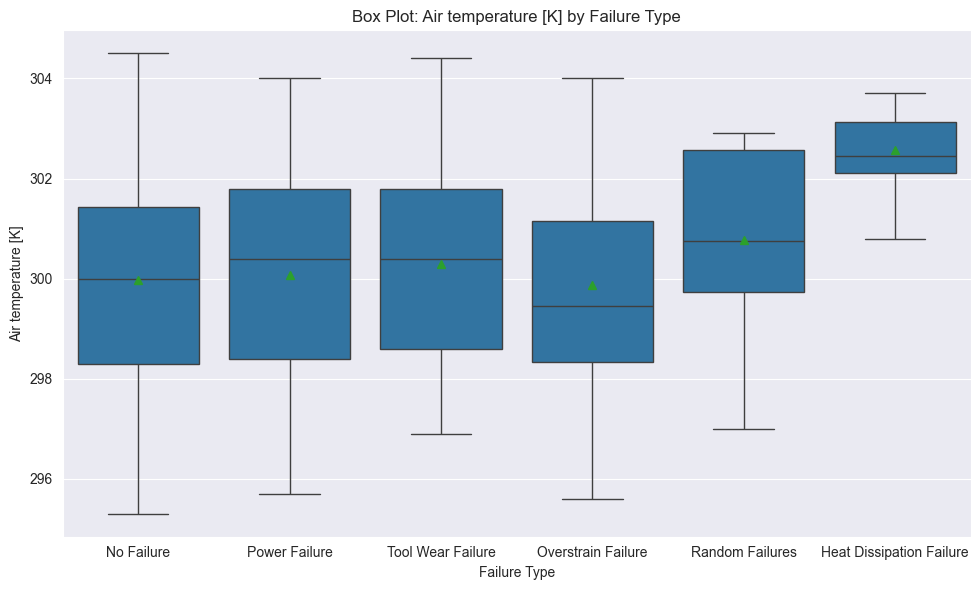

In [310]:
# Exploring Air temperature vs Failure Type using box plots. 
plt.figure(figsize=[10,6])
sns.boxplot(
    data=df, 
    x='Failure Type', 
    y='Air temperature [K]', 
    showmeans=True
)
plt.title("Box Plot: Air temperature [K] by Failure Type")
plt.tight_layout()
plt.show()

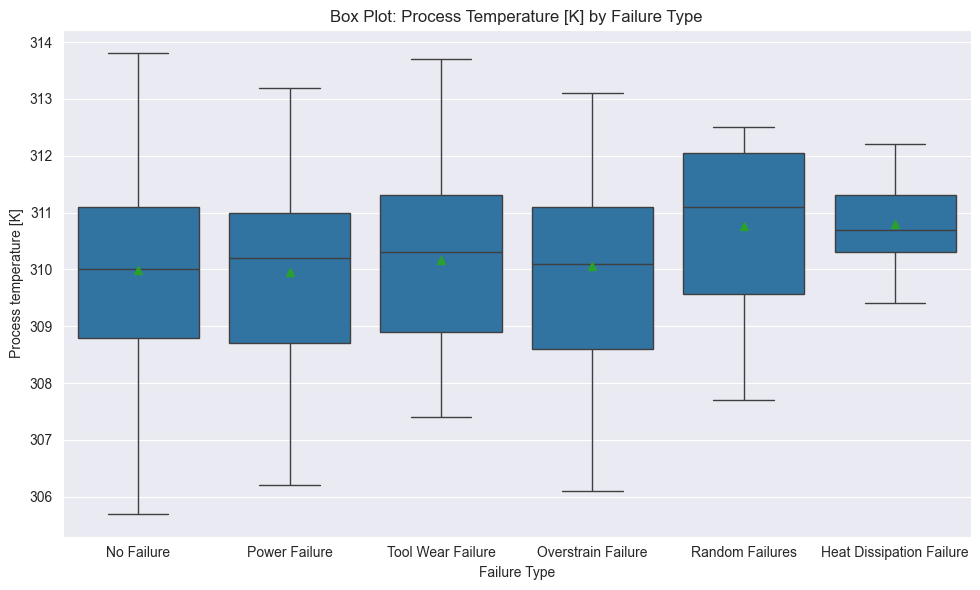

In [311]:
# Exploring Air temperature vs Failure Type using box plots. 
plt.figure(figsize=[10,6])
sns.boxplot(
    data=df, 
    x='Failure Type', 
    y='Process temperature [K]', 
    showmeans=True
)
plt.title("Box Plot: Process Temperature [K] by Failure Type")
plt.tight_layout()
plt.show()

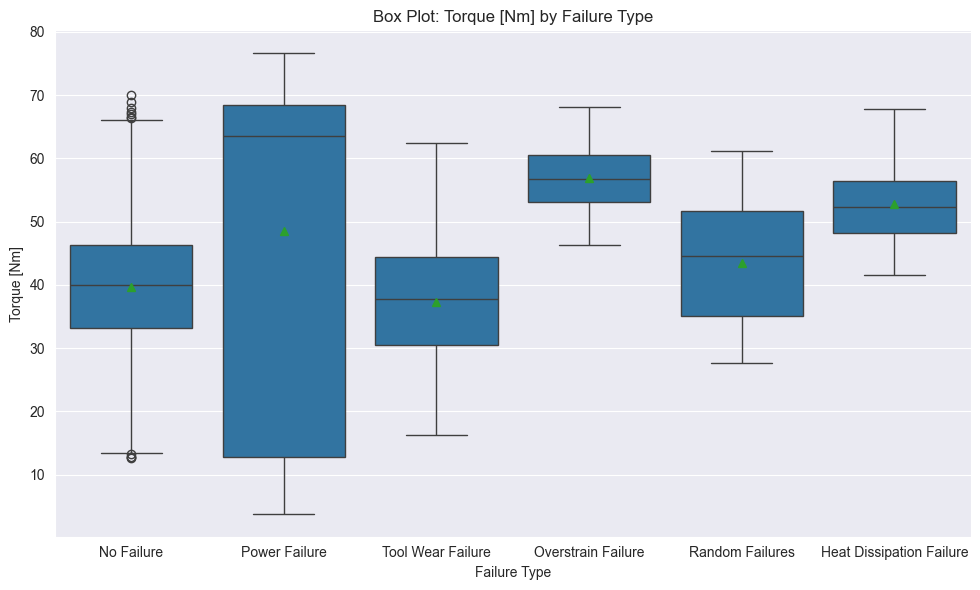

In [312]:
# Exploring Air temperature vs Failure Type using box plots. 
plt.figure(figsize=[10,6])
sns.boxplot(
    data=df, 
    x='Failure Type', 
    y='Torque [Nm]', 
    showmeans=True
)
plt.title("Box Plot: Torque [Nm] by Failure Type")
plt.tight_layout()
plt.show()

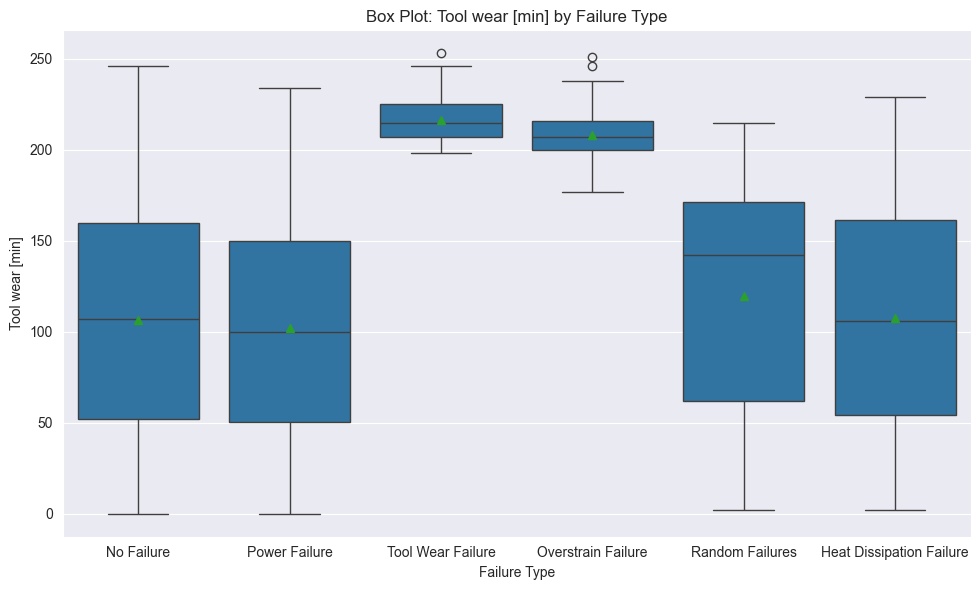

In [313]:
# Exploring Air temperature vs Failure Type using box plots. 
plt.figure(figsize=[10,6])
sns.boxplot(
    data=df, 
    x='Failure Type', 
    y='Tool wear [min]', 
    showmeans=True
)
plt.title("Box Plot: Tool wear [min] by Failure Type")
plt.tight_layout()
plt.show()

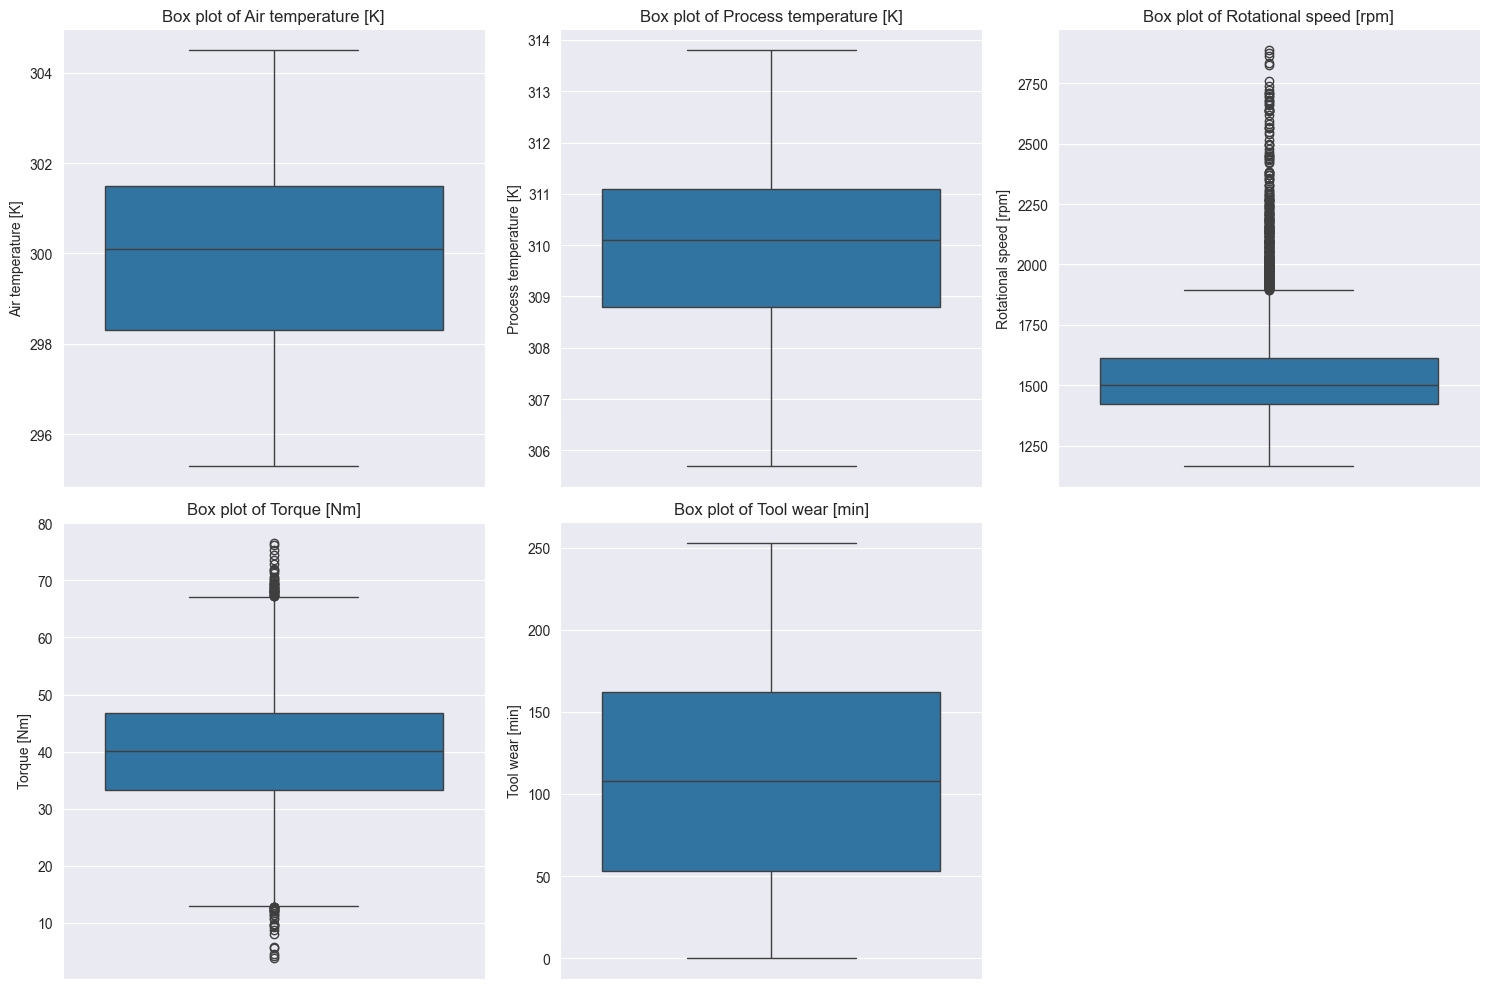

In [314]:
# Visualizing  box plots to check for outliers in numerical features.
plt.figure(figsize=(15, 10))
for i, col in enumerate([
    'Air temperature [K]', 
    'Process temperature [K]', 
    'Rotational speed [rpm]', 
    'Torque [Nm]', 
    'Tool wear [min]']
):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [315]:
# Handling missing values.
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [316]:
# Dropping 'UDI', 'Target' and 'Product ID' columns.
df.drop(columns=['UDI', 'Product ID', 'Target'], axis=1, inplace=True)

df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


In [317]:
# Cleaning columns names.
columns_to_rename = {
    'Air temperature [K]' : 'Air Temperature', 
    'Process temperature [K]' : 'Process Temperature', 
    'Rotational speed [rpm]' : 'Rotational Speed', 
    'Torque [Nm]' : 'Torque', 
    'Tool wear [min]' : 'Tool Wear', 
    'Failure Type' : 'Failure Type'
}
df.rename(columns=columns_to_rename, inplace=True)
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


In [318]:
# Encoding categorical variables.
# 'Type' column with values low, medium, and high are an ordinal column. 
# These values represent categories with a clear and natural order.
# L < M < H
# This order makes it suitable for ordinal encoding.
encoder = OrdinalEncoder()
df['Type_Encoded'] = encoder.fit_transform(df[['Type']])
df.head()

,Type,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Failure Type,Type_Encoded
0,M,298.1,308.6,1551,42.8,0,No Failure,2.0
1,L,298.2,308.7,1408,46.3,3,No Failure,1.0
2,L,298.1,308.5,1498,49.4,5,No Failure,1.0
3,L,298.2,308.6,1433,39.5,7,No Failure,1.0
4,L,298.2,308.7,1408,40.0,9,No Failure,1.0


In [319]:
# Dropping 'Type' column.
df.drop(columns=['Type'], axis=1, inplace=True)

#### Handling Outliers

In [320]:
# Handlling outliers in 'Rotational speed' column using winsorization.
rotational_q1 = df['Rotational Speed'].quantile(0.25)
rotational_q3 = df['Rotational Speed'].quantile(0.75)

rotational_iqr = rotational_q3 - rotational_q1

rotational_lower_bound = rotational_q1 - 1.5 * rotational_iqr
rotational_upper_bound = rotational_q3 + 1.5 * rotational_iqr

df['Rotational Speed'] = np.where(
    df['Rotational Speed'] < rotational_lower_bound, 
    rotational_lower_bound,
    np.where(
        df['Rotational Speed'] > rotational_upper_bound, 
        rotational_upper_bound, 
        df['Rotational Speed']
    )
)

# Handlling outliers in 'Torque [Nm]' column using winsorization.
torque_q1 = df['Torque'].quantile(0.25)
torque_q3 = df['Torque'].quantile(0.75)

torque_iqr = torque_q3 - torque_q1

torque_lower_bound = torque_q1 - 1.5 * torque_iqr
torque_upper_bound = torque_q3 + 1.5 * torque_iqr

df['Torque'] = np.where(
    df['Torque'] < torque_lower_bound, 
    torque_lower_bound,
    np.where(
        df['Torque'] > torque_upper_bound, 
        torque_upper_bound, 
        df['Torque']
    )
)

In [321]:
# Normalizing features.
scaler = StandardScaler()
features = [
    'Air Temperature', 
    'Process Temperature', 
    'Rotational Speed', 
    'Torque', 
    'Tool Wear', 
    'Type_Encoded'
]
df[features] = scaler.fit_transform(df[features])

df[features].head()

,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Type_Encoded
0,-0.952389,-0.947360,0.140180,0.284091,-1.695984,1.333889
1,-0.902393,-0.879959,-0.820899,0.637122,-1.648852,-0.332223
2,-0.952389,-1.014761,-0.216024,0.949807,-1.617430,-0.332223
3,-0.902393,-0.947360,-0.652879,-0.048768,-1.586009,-0.332223
4,-0.902393,-0.879959,-0.820899,0.001665,-1.554588,-0.332223


In [322]:
# Encoding the target variable 'Failure Type'.
df['Failure Type'] = df['Failure Type'].astype('category').cat.codes
df.head()

,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Failure Type,Type_Encoded
0,-0.952389,-0.947360,0.140180,0.284091,-1.695984,1,1.333889
1,-0.902393,-0.879959,-0.820899,0.637122,-1.648852,1,-0.332223
2,-0.952389,-1.014761,-0.216024,0.949807,-1.617430,1,-0.332223
3,-0.902393,-0.947360,-0.652879,-0.048768,-1.586009,1,-0.332223
4,-0.902393,-0.879959,-0.820899,0.001665,-1.554588,1,-0.332223


In [323]:
# Splitting the data into training and testing sets.
X = df[features]
y = df['Failure Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

## Handling Imbalanced Data

In [324]:
# Applying SMOTE to balance the classes.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train, 
    y_train
)

## Model Training and Hyperparameter Tuning


In [325]:
# Defining the parameter grid.
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(20, 50),
    'min_samples_split': randint(5, 10),
    'min_samples_leaf': randint(3, 5),
    'bootstrap': [True, False]
}

# Initialising the Random Forest Classifier.
rf_classifier = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced'
)

# Randomized search with cross-validation.
random_search = RandomizedSearchCV(
    estimator=rf_classifier, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=3, 
    n_jobs=-1, 
    random_state=42
)
random_search.fit(X_train_resampled, y_train_resampled)

# Getting the best estimator.
best_rf = random_search.best_estimator_

## Model Evaluation


Accuracy: 0.962
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        22
           1       0.99      0.97      0.98      1930
           2       0.70      0.88      0.78        16
           3       0.71      0.79      0.75        19
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9

    accuracy                           0.96      2000
   macro avg       0.51      0.60      0.55      2000
weighted avg       0.98      0.96      0.97      2000



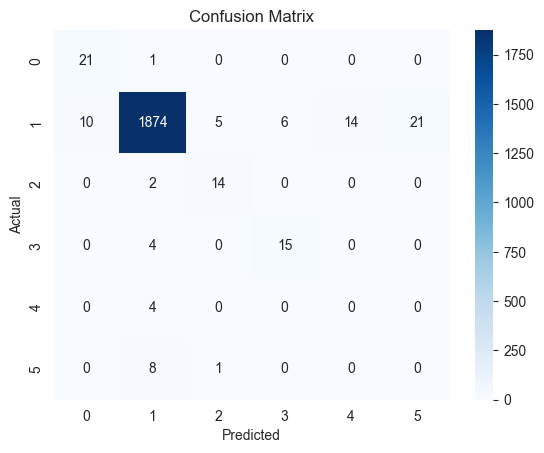

In [326]:
# Predicting on the test set.
y_pred = best_rf.predict(X_test)

# Evaluatting the model.
print("Accuracy:", accuracy_score(y_test, y_pred))

# Explicitly creatting the target names as strings.
target_names = df[
    'Failure Type'
].astype('category').cat.categories.astype(str).tolist()

print("Classification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=target_names, 
    zero_division=1
))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Conclusions

The dataset consisted of various machine features, including air temperature, process temperature, rotational speed, torque, and tool wear.

The target variable, "Failure Type," was highly imbalanced, with the majority class being "No Failure."

#### Model Performance:
The Random Forest classifier achieved an overall accuracy of 96%.

Precision, recall, and F1-scores varied across different failure types, with 4 and 5 minority classes being zero accurately predicted. 

Majority classes are High accurately predicted.

The use of SMOTE helped to mitigate the class imbalance issue.

#### Challenges and Limitations:
The primary challenge was the imbalanced nature of the target variable, which required careful handling using techniques like SMOTE.

Hyperparameter tuning was computationally expensive, requiring strategies to reduce search space and iterations.

#### Future Improvements:
Collecting more data for minority failure types could help improve model performance.

Exploring different algorithms and ensemble methods may yield better results.

Further tuning and optimization of hyperparameters can be conducted with more computational resources.